# Solve edit distance by DAGs

In [34]:
# implement edit distance via dynamic programming

cost_copy = 0
cost_insert = 1
cost_delete = 1

def edit_distance(s1, s2):
    m = len(s1)
    n = len(s2)
    dp = [[0 for j in range(n+1)] for i in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(
                    dp[i-1][j] + cost_delete,
                    dp[i][j-1] + cost_insert,
                    dp[i-1][j-1] + cost_copy
                )
    return dp[m][n]

In [35]:
A = "monkey"
B = "money"
edit_distance(A, B)

1

In [36]:
# Solve edit distance using a directed acyclic graph (DAG)

# Construct a state space graph where each node represents a state of the edit distance computation
# Each node in the DAG represents a pair of integers (i, j) where i is the index of the character in string A
# and j is the index of the character in string B

# The edges between nodes represent transitions from one state to another based on
# insert: (i,j) -> (i-1,j)
# delete: (i,j) -> (i,j-1)
# copy: (i,j) -> (i-1,j-1)

import networkx as nx

def construct_DAG_from_A_B(A, B):
    # A: source string
    # B: target string
    graph = nx.grid_2d_graph(len(B)+1,len(A)+1)

    for i in range(len(B)+1):
        for j in range(len(A)+1):
            if i > 0:
                graph.add_edge((i,j),(i-1,j), label="insert")
            if j > 0:
                graph.add_edge((i,j),(i,j-1), label="delete")
            if i > 0 and j > 0:
                if B[i-1] == A[j-1]:
                    graph.add_edge((i,j),(i-1,j-1), label="copy")
    return graph

graph = construct_DAG_from_A_B(A, B)

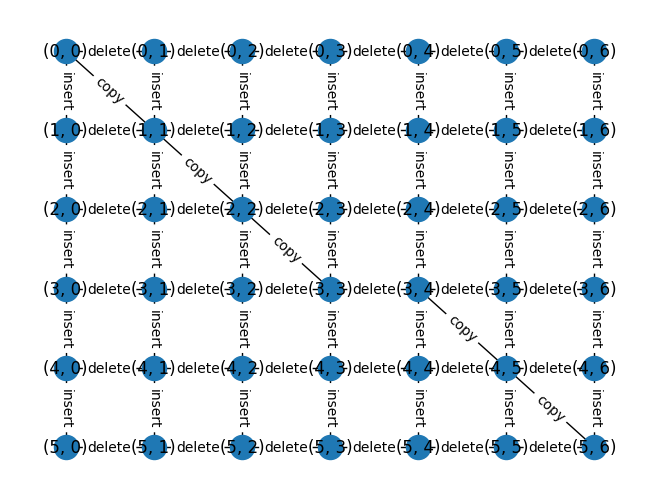

In [37]:
# visualize graph
import matplotlib.pyplot as plt
pos = {(x,y):(y,-x) for x,y in graph.nodes()}
nx.draw(graph, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(graph, 'label')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    
plt.show()


# Solve longest increase distance by DAG relaxation

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# sequence
seq = [1, 3, 5, 2, 4, 6, 7, 8, 9]

# construct a DAG from the sequence
def construct_DAG_from_seq(seq):
    graph = nx.DiGraph()
    for i in range(len(seq)):
        graph.add_node(i, label=str(seq[i]))
        
    for i in range(len(seq)):
        for j in range(i+1, len(seq)):
            if seq[j] > seq[i]:
                graph.add_edge(i,j, weight=-1)
    return graph

graph = construct_DAG_from_seq(seq)

# add source and sink nodes
graph.add_node(-1, label="s")
graph.add_node(len(seq), label="t")
for i in range(len(seq)):
    graph.add_edge(-1,i, weight=-1)
    graph.add_edge(i,len(seq), weight=-1)


In [39]:
def DAG_relaxation(graph, order, source):
    D = {v: float('inf') for v in graph}
    P = {v: None for v in graph}
    D[source] = 0
    P[source] = source

    for u in order:
        for v, w_dict in graph[u].items(): # adjacency list
            d_suv = D[u] + w_dict['weight']
            if D[v] > d_suv:
                D[v] = d_suv
                P[v] = u

    return D, P

def get_path(P, start, end):
    path = []
    current = end
    while current != start:
        path.append(current)
        current = P[current]
    path.append(start)
    return path[::-1]

order = [i for i in range(-1, len(seq)+1)]
D, P = DAG_relaxation(graph, order, -1)
path = get_path(P, -1, len(seq))

LIS = [seq[idx] for idx in path[1:-1]]
print("Original sequence: [1, 3, 5, 2, 4, 6, 7, 8, 9]")
print("LIS:", LIS)

Original sequence: [1, 3, 5, 2, 4, 6, 7, 8, 9]
LIS: [1, 3, 5, 6, 7, 8, 9]


# Solve 0-1 Knapsack via DAG relaxation

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# values = [60, 100, 120]
# weights = [10, 20, 30]

values = [6, 10, 12]
weights = [1, 2, 3]
W = 5

# construct a state space graph where node (i, remW) represents the maximum value that can be obtained
# by considering items 0 to i with remaining weight remW
# edges between nodes represent transitions from one state to another based on

# include: (i, remW) -> (i+1, remW - weights[i]) where edge weight = weights[i]
# exclude: (i, remW) -> (i+1, remW) where edge weight = 0

def construct_DAG_from_values_weights(values, weights, W):
    graph = nx.DiGraph()
    for i in range(len(values)+1):
        for remW in range(W+1):
            graph.add_node((i,remW), label=str((values[i-1], weights[i-1])) if i > 0 else "s")
    
    for i in range(len(values)):
        for remW in range(W+1):
            if remW >= weights[i]:
                graph.add_edge((i,remW), (i+1,remW-weights[i]), weight=-values[i])
            graph.add_edge((i,remW), (i+1,remW), weight=0)
    return graph

graph = construct_DAG_from_values_weights(values, weights, W)


0 Value: -22
1 Value: -18
2 Value: -16
3 Value: -10
4 Value: -6
[(0, 5), (1, 5), (2, 3), (3, 0)]


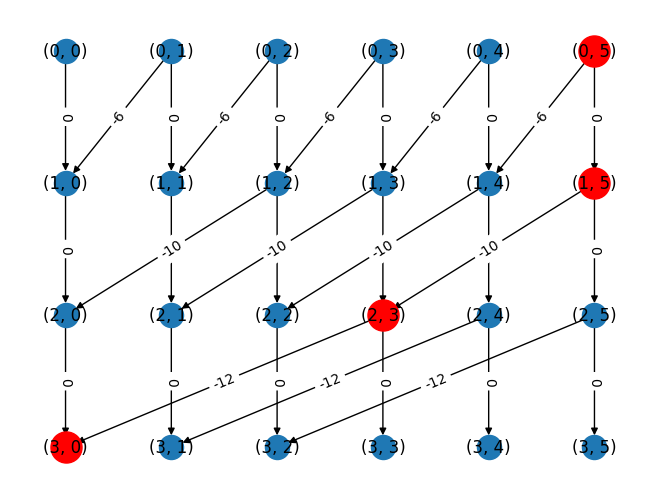

In [46]:
# make a list of nodes in topological order
n = len(values)
order = [(i, remW) for i in range(len(values)+1) for remW in range(W+1)]
D, P = DAG_relaxation(graph, order, (0,W))
for i in range(W):
    print(i, "Value:", D[(n,i)])

# find argmax among D[n,i] for i in range(W)
# max_value = max(D[(n,i)] for i in range(W))

path = get_path(P, (0,W), (n,0))
print(path)
# draw graph with path
nx.draw(graph, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color='r', node_size=500)
plt.show()

